### Import dependencies 

In [31]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import requests

### Creating a function to hit the dbt Cloud Discovery API to grab project lineage

In [96]:
def get_lineage_from_disco_api(dbt_cloud_env_id, dbt_cloud_auth_token, resources_to_get = ["Source","Seed","Model","Snapshot","Exposure"], tag_filter=None):

    # The dbt Cloud Disocvery API GraphQL endpoint
    url = 'https://metadata.cloud.getdbt.com/graphql'
    
    # The GraphQL query and variables
    query = """
    query Lineage($environmentId: BigInt!, $filter: AppliedResourcesFilter!) {
      environment(id: $environmentId) {
        applied {
          lineage(filter: $filter) {
            parentIds
            uniqueId
          }
        }
      }
    }
    """
    # check if there is a tag filter or not
    tag_to_filter_for = None if tag_filter==None else f'{tag_filter}'
    
    # Variables for your query
    variables = {
      "environmentId": dbt_cloud_env_id,
      "filter": {
        "types": resources_to_get,
        "tags": tag_to_filter_for
      }
    }
    
    # Prepare the payload
    payload = {
        "query": query,
        "variables": variables
    }
    
    # Set headers
    headers = {"Authorization": f"Bearer {dbt_cloud_auth_token}"}
    
    # Send the POST request
    response = requests.post(url, json=payload, headers=headers)
    
    # Convert JSON into a dict and grab lineage
    converted_response = response.json()['data']['environment']['applied']['lineage']
    
    # Check for errors
    if response.status_code == 200:
        print('Response sucessfully received from dbt Cloud Discovery API')
    else:
        print(f'Query failed with status code {response.status_code}: {response.text}')

    # return lineage
    return converted_response

### Creating a function to parse the lineage data from the dbt Cloud Discovery API

In [86]:
def parsed_returned_lineage_data(lineage_data):

    lineage_data_parse = lineage_data
    
    # get a list of all the unique ids
    unique_ids = [item['uniqueId'] for item in lineage_data_parse]
    
    # filter out all parent ids that will not be graph nodes
    for item in lineage_data_parse:
        item['parentIds'] = [pid for pid in item['parentIds'] if pid in unique_ids]
    
    # filter out all parent ids that are not objects (tests and macros)
    for item in lineage_data_parse:
        item['parentIds'] = [pid for pid in item['parentIds'] if pid.split('.')[0] in ["source","seed","model","snapshot","exposure"]]
    
    # parsing some additonal details out of the returned JSON
    for graph_object in lineage_data_parse:
    
        # add extra detail to the graph object for use in plotting
        graph_object['object_type'] = graph_object['uniqueId'].split('.')[0]
        graph_object['project_name'] = graph_object['uniqueId'].split('.')[1]
    
        if graph_object['object_type'] == 'source':
            graph_object['object_name'] = graph_object['uniqueId'].split('.')[2] + "." + graph_object['uniqueId'].split('.')[3]
        else:
            graph_object['object_name'] = graph_object['uniqueId'].split('.')[2]
    
        # need a black dict to put all parent info into
        parent_info_dict = []
    
        # add extra detail for each partent related to the given object
        for parent_num in range(len(graph_object['parentIds'])):
    
            parent_id = graph_object['parentIds'][parent_num]
            parent_object_type = parent_id.split('.')[0]
            parent_project_name = parent_id.split('.')[1]
    
            if parent_object_type == 'source':
                parent_object_name = (parent_id.split('.')[2]) + "." + (parent_id.split('.')[3])
            else:
                parent_object_name = parent_id.split('.')[2]
    
         
            parent_info_dict.append({'unique_id': parent_id, 
                                     'parent_object_type': parent_object_type, 
                                     'parent_project_name': parent_project_name, 
                                     'parent_object_name': parent_object_name})
                
        # add info into object 
        graph_object['parent_details'] = parent_info_dict

    return lineage_data_parse

### Creating a function to plot a simplified lineage graph

In [64]:
# Trying to use the graphviz_layout from networkx if available

def create_simple_lineage_graph(lineage_data):

    # make sure dependencies are imported
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
    except ImportError:
        try:
            # Alternative if pygraphviz is not installed
            from networkx.drawing.nx_pydot import graphviz_layout
        except ImportError:
            print("Both pygraphviz and pydot were not found, they are required for the graphviz layout.")
    
    # Reinitialize the graph to avoid duplications
    G = nx.DiGraph()
    
    # Corrected node colors based on object type
    node_colors = {
        "source": "#a6e0e0",
        "model": "#bae6fd",
        "exposure": "#ffa588",
        "snapshot": "#fbbbef",
        "seed": "#bbfdba"
    }
    
    default_color = "grey"
    
    # Add nodes and edges to the graph, ensuring every node has a color attribute
    for item in lineage_data:
        object_id = item['uniqueId']
        object_type = item['object_type']
        parent_ids = item['parentIds']
    
        # Add the current node with a default color if its type isn't recognized
        G.add_node(object_id, color=node_colors.get(object_type, default_color), shape='rectangle')
    
        # Add edges from parents to the current node
        for p_id in parent_ids:
            # Add the parent node if it doesn't exist
            if not G.has_node(p_id):
                G.add_node(p_id, color=default_color, shape='rectangle')
            G.add_edge(p_id, object_id)
    
    # Increase figure size
    plt.figure(figsize=(20, 20))
    
    # Extract 'object_name' for labels
    labels = {item['uniqueId']: item['object_name'] for item in lineage_data}
    
    # Adjust layout parameters to spread out the nodes more
    pos_adjusted = graphviz_layout(G, prog='dot')
    
    # Flip horizontally
    pos_adjusted_flipped = {node: (-y, x) for node, (x, y) in pos_adjusted.items()}
    
    # Nodes
    nodes = nx.draw_networkx_nodes(G, pos_adjusted_flipped, node_color=[n[1]['color'] for n in G.nodes(data=True)], node_shape='s', node_size=1750)
    nodes.set_edgecolor('black')  # set node border color
    
    # Edges
    nx.draw_networkx_edges(G, pos_adjusted_flipped)
    
    # Labels
    nx.draw_networkx_labels(G, pos_adjusted_flipped, labels=labels, font_size=8)
    
    plt.axis('off')

    # return the plot
    return plt

### Creating a function to graph the lineage out but with more configs to make the viz look cleaner

In [99]:
def create_custom_lineage_graph(lineage_data):
        
    # Trying to use the graphviz_layout from networkx if available
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
    except ImportError:
        try:
            # Alternative if pygraphviz is not installed
            from networkx.drawing.nx_pydot import graphviz_layout
        except ImportError:
            print("Both pygraphviz and pydot were not found, they are required for the graphviz layout.")
    
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Define node colors based on object types
    node_colors = {
        "source": "#a6e0e0",
        "model": "#bae6fd",
        "exposure": "#ffa588",
        "snapshot": "#fbbbef",
        "seed": "#bbfdba"
    }
    
    # Default color for nodes whose type is not specified in node_colors
    default_color = 'gray'
    
    # Add nodes and edges to the graph, ensuring every node has a color attribute
    for item in lineage_data:
        object_id = item['uniqueId']
        object_type = item['object_type']
        parent_ids = item['parentIds']
        object_name = item['object_name']
    
        # Add the current node with a default color if its type isn't recognized
        G.add_node(object_id, object_name=object_name, color=node_colors.get(object_type, default_color), shape='rectangle', )
    
        # Add edges from parents to the current node
        for p_id in parent_ids:
            # Add the parent node if it doesn't exist
            if not G.has_node(p_id):
                G.add_node(p_id, color=default_color, shape='rectangle')
            G.add_edge(p_id, object_id)
    
    # Generate the layout for a left-to-right directed graph
    pos = graphviz_layout(G, prog='dot')
    
    # Adjust the layout
    pos_adjusted_flipped = {node: (-y, x) for node, (x, y) in pos.items()}
    
    # Define a function to draw rectangles with the correct color and position
    def draw_rectangles(G, pos, ax, labels, base_width=0.2, height=0.1, edgecolor='black', linewidth=1):
        for node in G.nodes():
            try:
                color = G.nodes[node]['color']
            except:
                print(G.nodes[node])
                color = 'gray'
            x, y = pos[node]
            node_label = labels[node]
            # Adjust the width based on the length of the node label
            width = base_width + len(node_label) * .75  # Adjust multiplier as needed
            rect = Rectangle((x - width / 2, y - height / 2), width, height, color=color, ec=edgecolor, lw=linewidth)
            ax.add_patch(rect)
            G.nodes[node]['patch'] = rect
            rect.set_zorder(3)  # Ensure rectangles are on top
        return None
    
    
    # Extract 'object_name' for labels
    labels = {item['uniqueId']: item['object_name'] for item in lineage_data}
    
    # Get range of x and y for setting plot limits
    x_values, y_values = zip(*pos_adjusted_flipped.values())
    x_min, x_max, y_min, y_max = min(x_values), max(x_values), min(y_values), max(y_values)
    # Increase the margin values for more padding
    x_margin, y_margin = (x_max - x_min) * 0.15, (y_max - y_min) * 0.15  # Increase margin for more padding
    
    # Increase figure width for a wider aspect ratio and set limits based on node positions
    fig, ax = plt.subplots(figsize=(30, 20))
    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    # Draw the rectangles as nodes, adjust width and height if necessary
    draw_rectangles(G, pos_adjusted_flipped, ax, labels=labels, base_width=25, height=100, edgecolor='black', linewidth=1)
    
    # Draw edges
    edges = nx.draw_networkx_edges(G, pos_adjusted_flipped, ax=ax)
    
    # Draw labels with smaller font size
    labels_plotted = nx.draw_networkx_labels(G, pos_adjusted_flipped, labels=labels, font_size=8, ax=ax)

    # turn off the axis
    plt.axis('off')

    # return the plot
    return plt

# Examples of using the code

## Define the parameters needed ton hit the dbt Cloud Discovery API

In [84]:
# defining the dbt Cloud Auth Token
dbt_cloud_auth_token = '<<dbt Cloud Service Token>>'

# defining the dbt Cloud Env ID 
dbt_cloud_env_id = 12345

## Example 1: Creating the simple lineage graph of all nodes

Response sucessfully received from dbt Cloud Discovery API


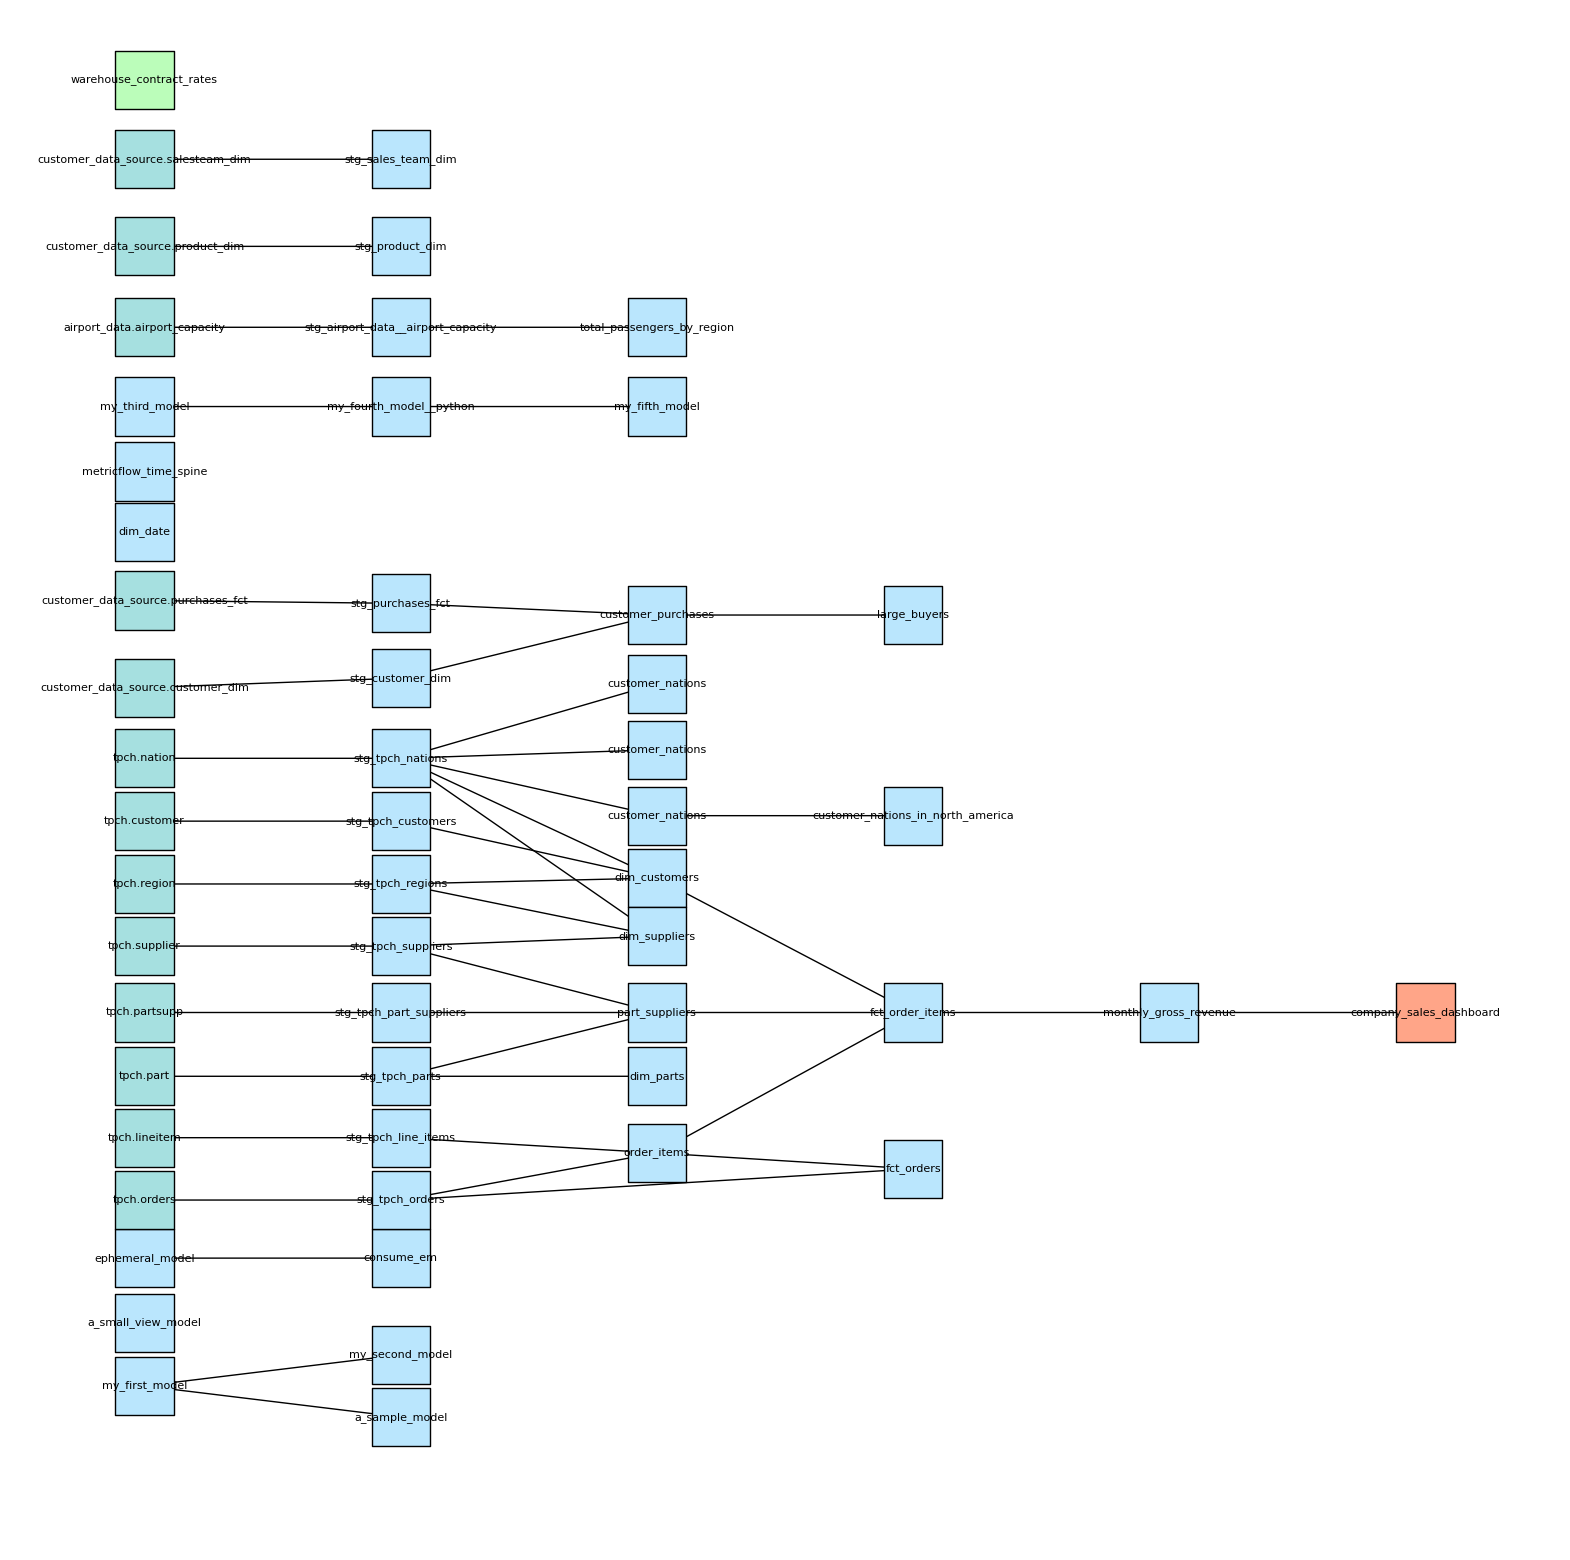

In [100]:
# get the lineage data from the dbt Cloud Discovery API
dbt_cloud_project_lineage_data = get_lineage_from_disco_api(dbt_cloud_env_id, dbt_cloud_auth_token)

# parse the lineage data
parsed_lineage_data = parsed_returned_lineage_data(dbt_cloud_project_lineage_data)

# create the lineage data plot
full_lineage_graph = create_simple_lineage_graph(parsed_lineage_data)

## Example 2: Creating the more custom lineage graph of all nodes

Response sucessfully received from dbt Cloud Discovery API


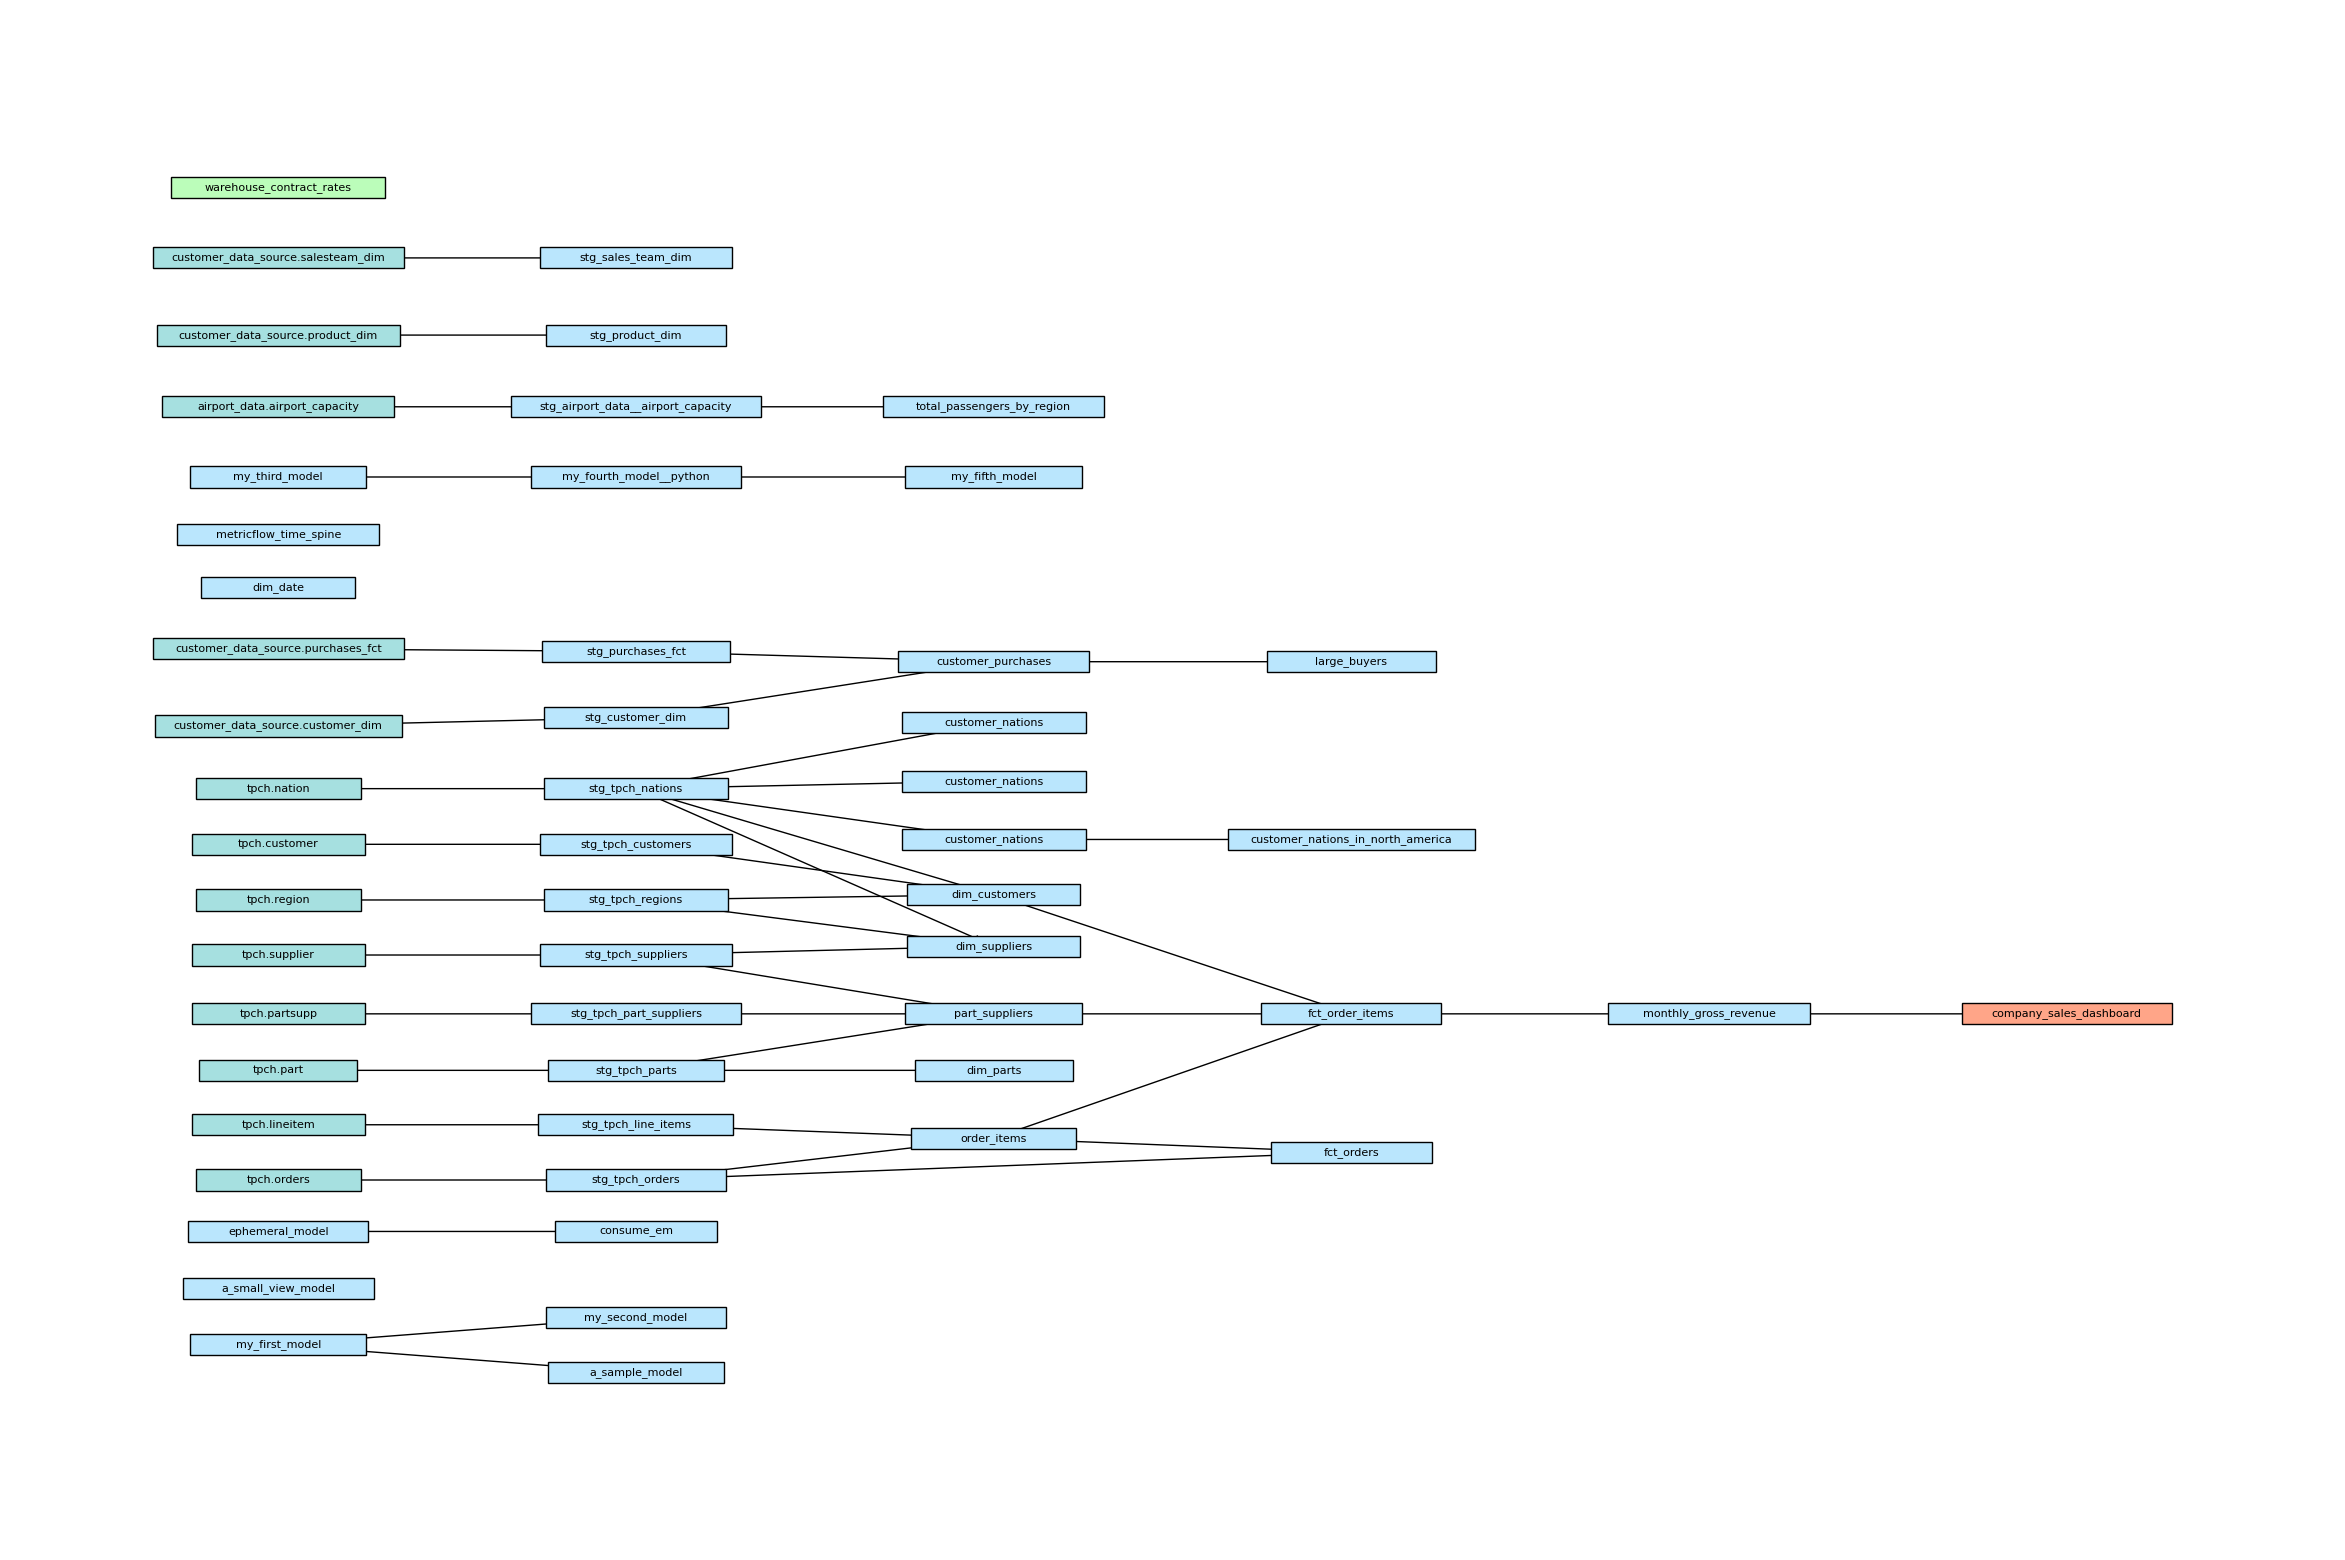

In [101]:
# get the lineage data from the dbt Cloud Discovery API
dbt_cloud_project_lineage_data = get_lineage_from_disco_api(dbt_cloud_env_id, dbt_cloud_auth_token)

# parse the lineage data
parsed_lineage_data = parsed_returned_lineage_data(dbt_cloud_project_lineage_data)

# create the lineage data plot
full_lineage_graph = create_custom_lineage_graph(parsed_lineage_data)

## Example 3: Creating a lineage graph when filtering for a tag

Response sucessfully received from dbt Cloud Discovery API


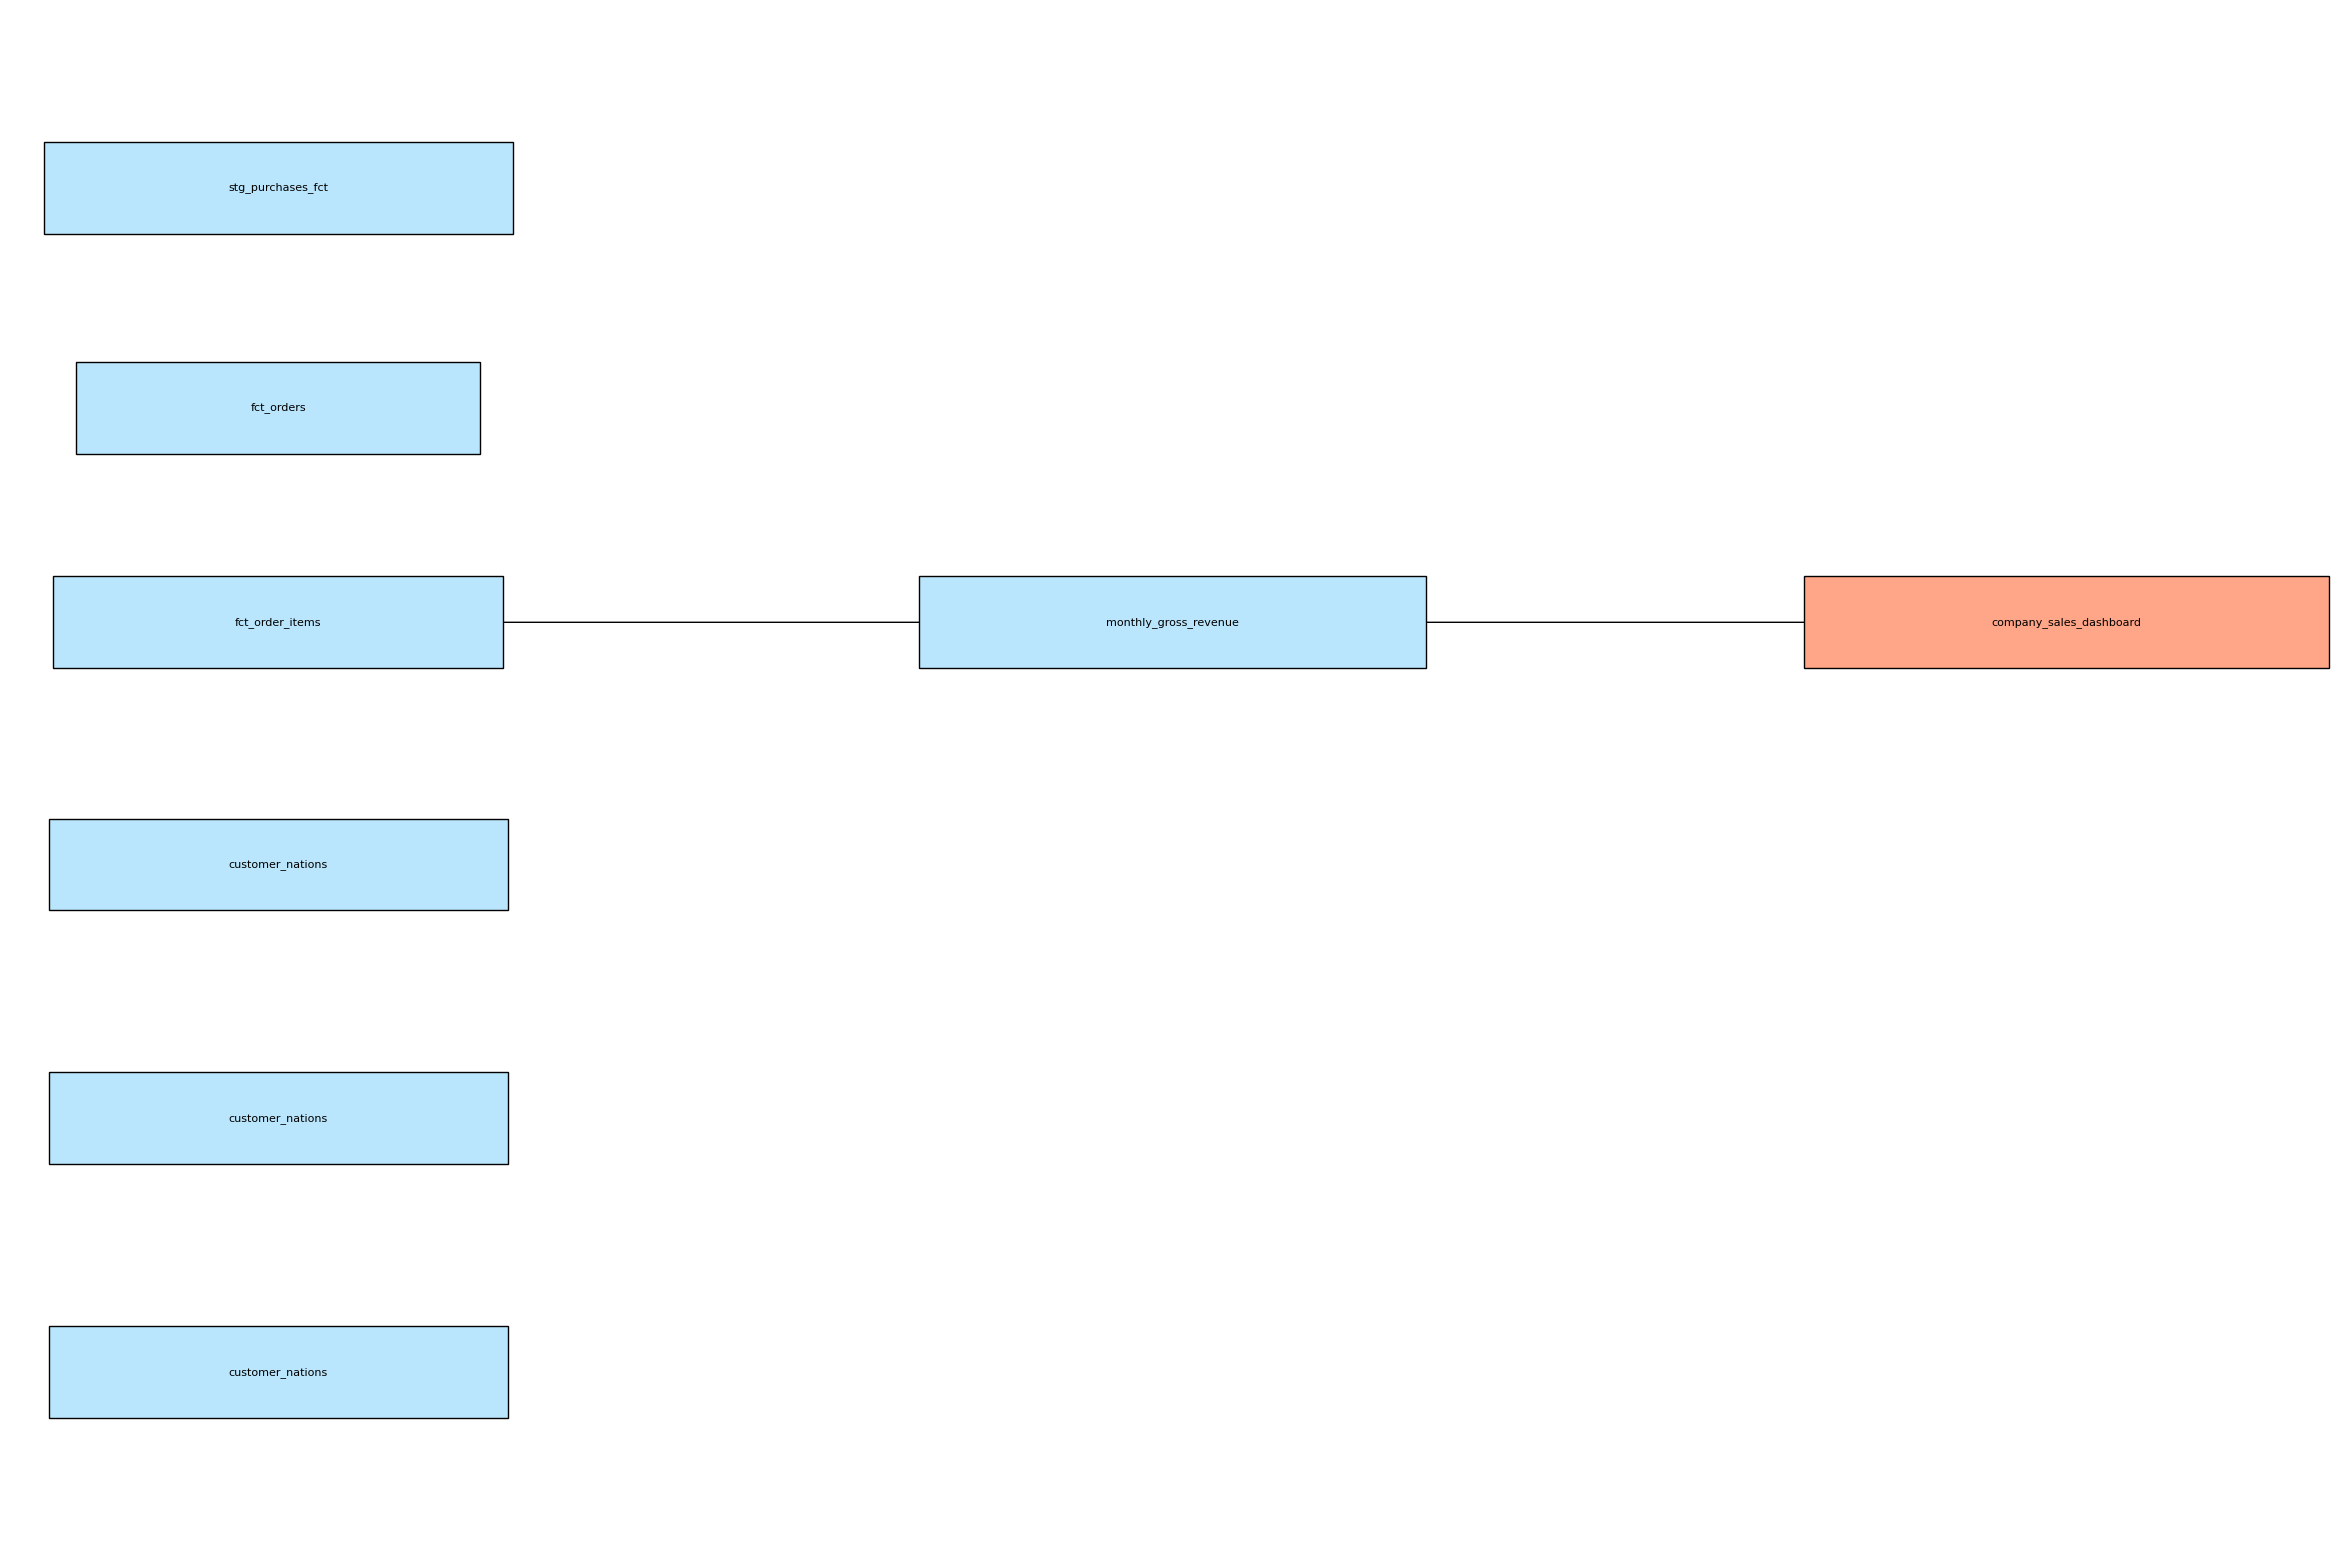

In [102]:
# get the lineage data from the dbt Cloud Discovery API
dbt_cloud_project_lineage_data = get_lineage_from_disco_api(dbt_cloud_env_id, dbt_cloud_auth_token, tag_filter="finance")

# parse the lineage data
parsed_lineage_data = parsed_returned_lineage_data(dbt_cloud_project_lineage_data)

# create the lineage data plot
tag_filtered_lineage_graph = create_custom_lineage_graph(parsed_lineage_data)

## Example 4: Creating a lineage graph when filtering for only models

Response sucessfully received from dbt Cloud Discovery API


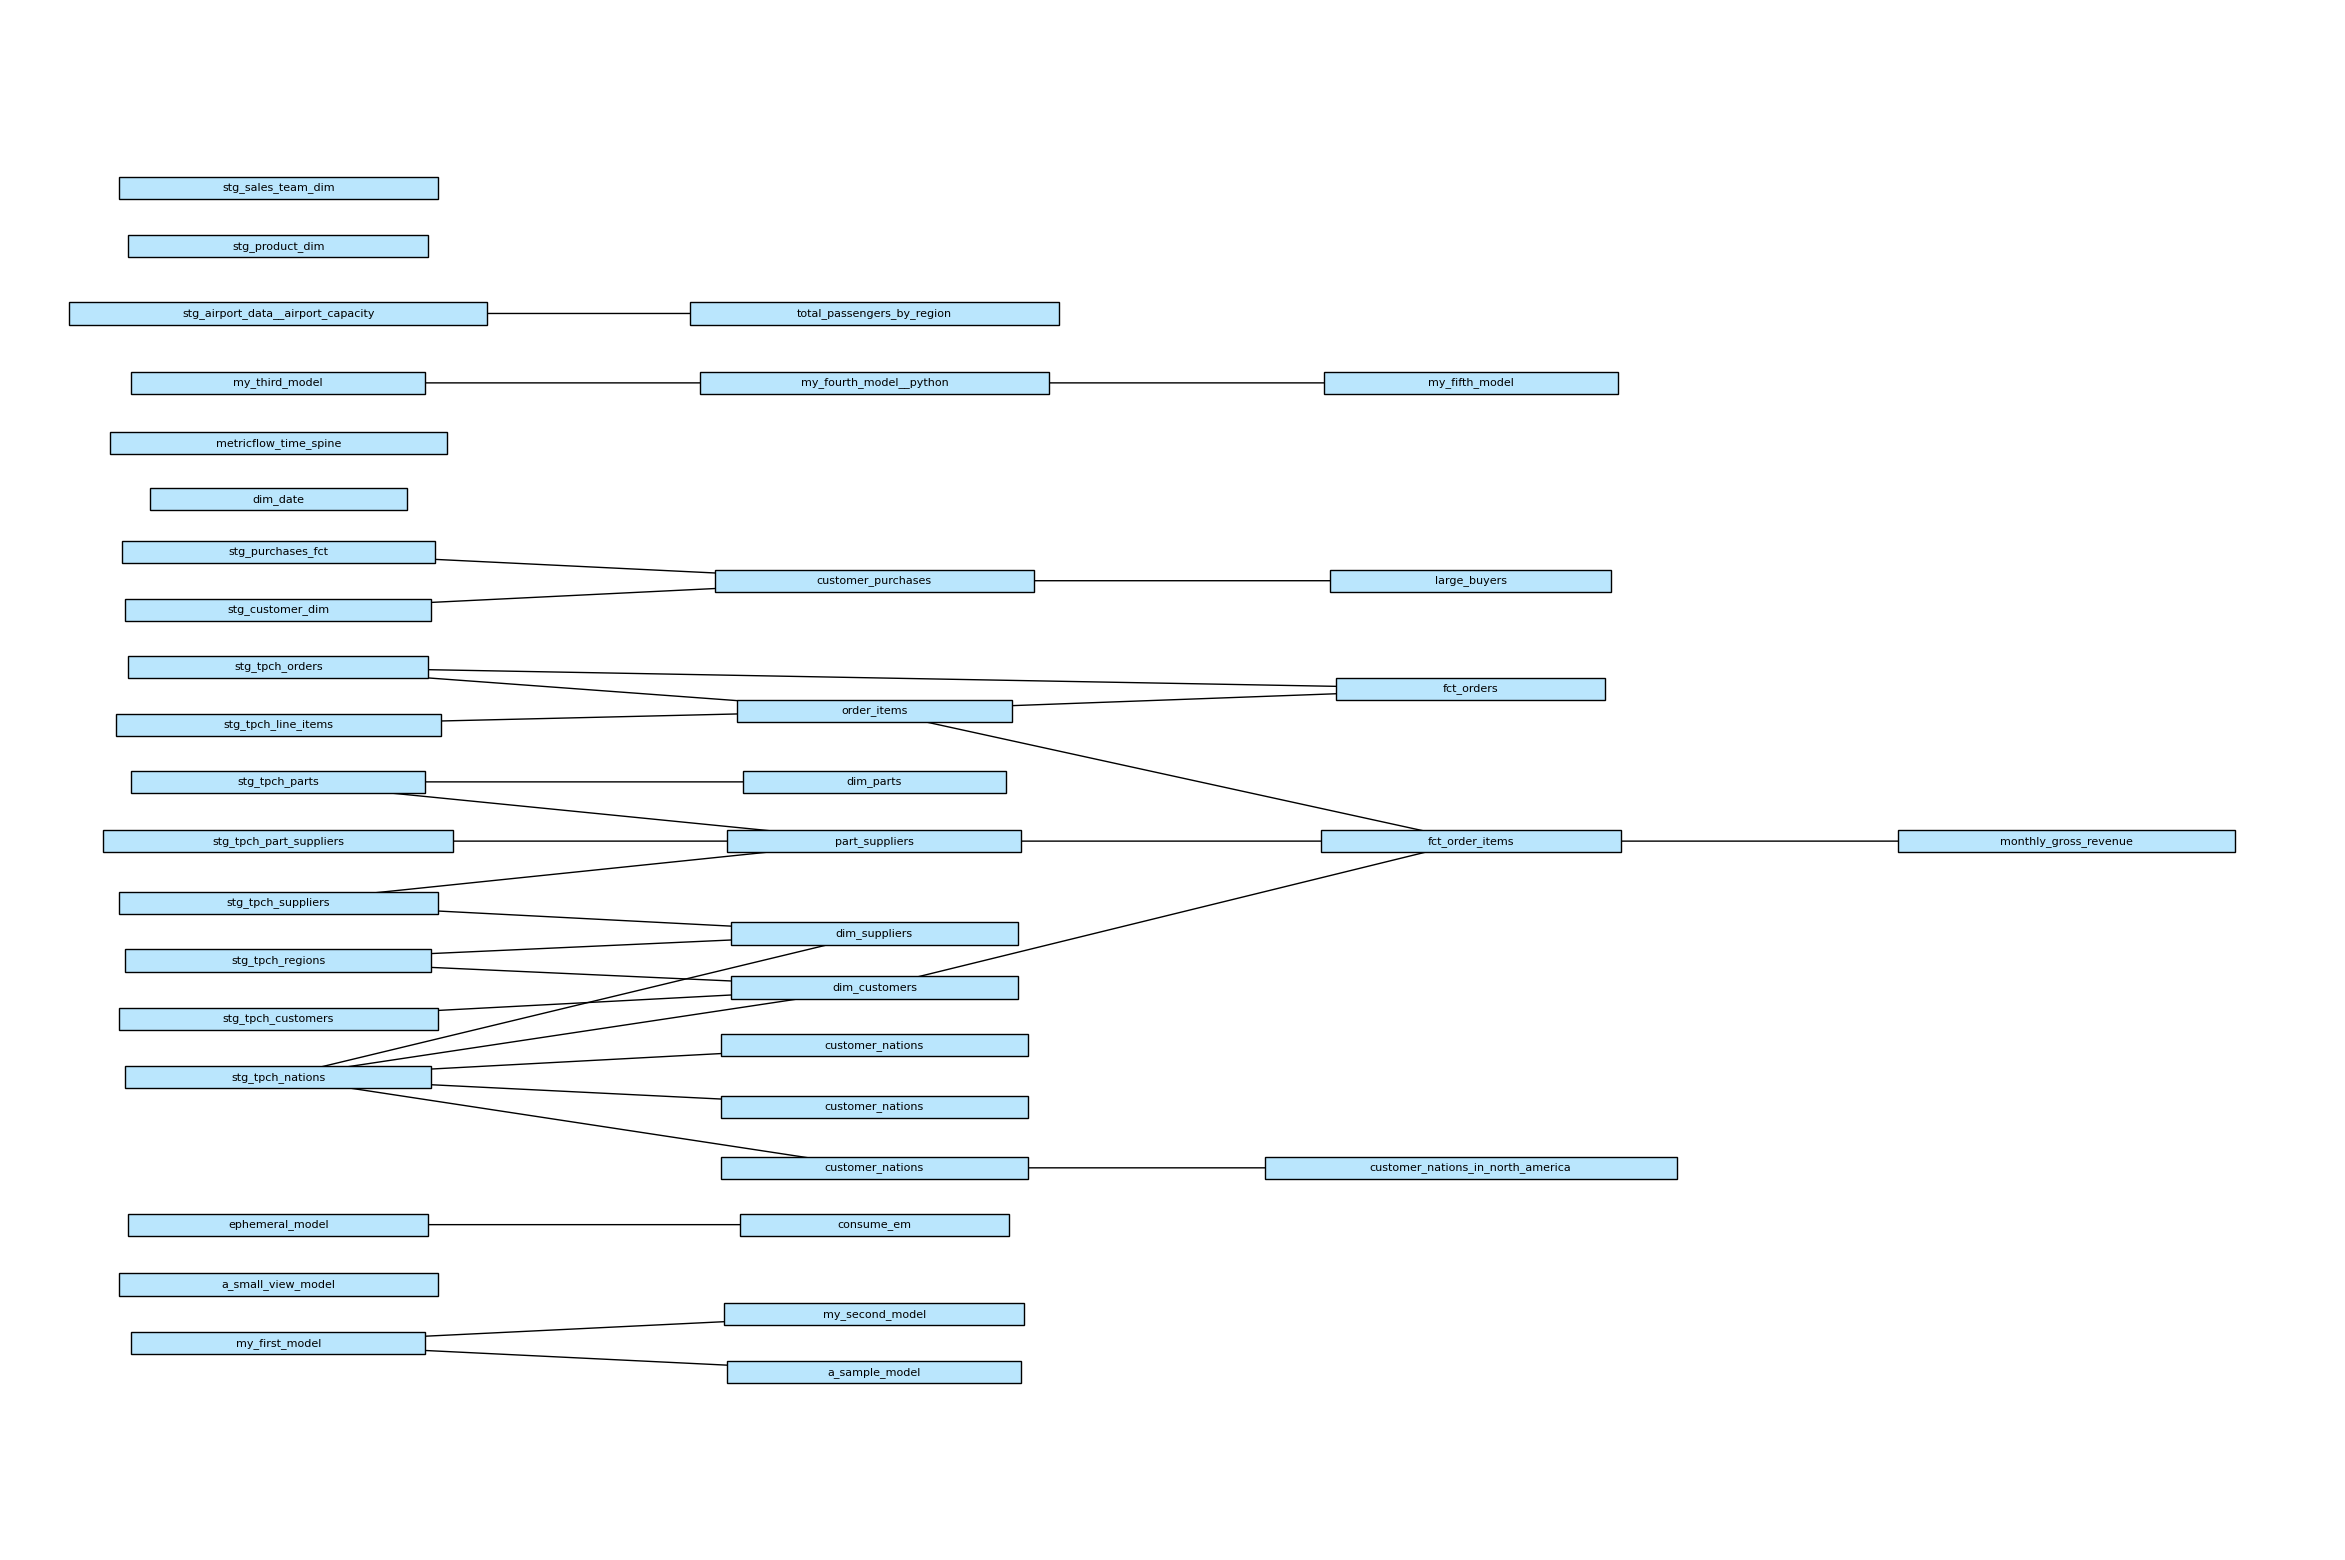

In [103]:
# get the lineage data from the dbt Cloud Discovery API
dbt_cloud_project_lineage_data = get_lineage_from_disco_api(dbt_cloud_env_id, dbt_cloud_auth_token, resources_to_get = ["Model"])

# parse the lineage data
parsed_lineage_data = parsed_returned_lineage_data(dbt_cloud_project_lineage_data)

# create the lineage data plot
tag_filtered_lineage_graph = create_custom_lineage_graph(parsed_lineage_data)

# END OF SCRIPT